In [1]:
__author__ = 'Dan Suson <djsuson@fnal.gov>' # single string; emails in <>
__version__ = '20210611' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['delve_dr1','gaia_edr3']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

In [2]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as mlt
import healpy as hp
import pandas as pd
%matplotlib inline

In [3]:
# set up variable values to use in analysis
areas = [[-20,-10,120,135]]
bands = ['g', 'r', 'i', 'z']
lower_spread_limit = -0.025
upper_spread_limit = 0.045
lower_mag_limit = -10
upper_mag_limit = 26
min_spread = 0.003
wide_spread = 0.005
skim = 100

In [4]:
def get_data(area):
  # getting necessary columns from DELVE within a certain RA and DEC
  sql_delve =\
  '''
  SELECT quick_object_id,
  spread_model_g,spreaderr_model_g,mag_auto_g,magerr_auto_g,
  spread_model_r,spreaderr_model_r,mag_auto_r,magerr_auto_r,
  spread_model_i,spreaderr_model_i,mag_auto_i,magerr_auto_i,
  spread_model_z,spreaderr_model_z,mag_auto_z,magerr_auto_z
  FROM delve_dr1.objects
  WHERE dec>{:f} and dec<{:f} and ra>{:f} and ra<{:f}
  '''.format(area[0],area[1],area[2],area[3])
  df1 = qc.query(sql=sql_delve,fmt='pandas')

  # getting all objects from similar patch of sky from gaia x delve data
  sql_gaia =\
  '''
  SELECT *
  FROM gaia_edr3.x1p5__gaia_source__delve_dr1__objects
  WHERE dec1>{:f} and dec1<{:f} and ra1>{:f} and ra1<{:f}
  '''.format(area[0],area[1],area[2],area[3])
  df2 = qc.query(sql=sql_gaia,fmt='pandas')

  return df1, df2

In [5]:
def apply_basic_cuts(*bands):

  nbands = len(bands)
  good_data = (delve_df[f'mag_auto_{bands[0]}'] > lower_mag_limit) & (delve_df[f'mag_auto_{bands[0]}'] < upper_mag_limit) \
            & (delve_df[f'spread_model_{bands[0]}'] > lower_spread_limit) & (delve_df[f'spread_model_{bands[0]}'] < upper_spread_limit)
  if nbands > 1:
    good_data = good_data[delve_df[f'mag_auto_{bands[1]}'] > lower_mag_limit][delve_df[f'mag_auto_{bands[1]}'] < upper_mag_limit]\
                         [delve_df[f'spread_model_{bands[1]}'] > lower_spread_limit][delve_df[f'spread_model_{bands[1]}'] < upper_spread_limit]
  if nbands > 2:
    good_data = good_data[delve_df[f'mag_auto_{bands[2]}'] > lower_mag_limit][delve_df[f'mag_auto_{bands[2]}'] < upper_mag_limit]\
                         [delve_df[f'spread_model_{bands[2]}'] > lower_spread_limit][delve_df[f'spread_model_{bands[2]}'] < upper_spread_limit]
  if nbands > 3:
    good_data = good_data[delve_df[f'mag_auto_{bands[3]}'] > lower_mag_limit][delve_df[f'mag_auto_{bands[3]}'] < upper_mag_limit]\
                         [delve_df[f'spread_model_{bands[3]}'] > lower_spread_limit][delve_df[f'spread_model_{bands[3]}'] < upper_spread_limit]

  return good_data

In [6]:
def create_arrays():
  mag_auto_bands = [np.array(delve_df['mag_auto_g'][indices]),np.array(delve_df['mag_auto_r'][indices]),np.array(delve_df['mag_auto_i'][indices]),np.array(delve_df['mag_auto_z'][indices])]
  spread_model_bands = [np.array(delve_df['spread_model_g'][indices]),np.array(delve_df['spread_model_r'][indices]),np.array(delve_df['spread_model_i'][indices]),np.array(delve_df['spread_model_z'][indices])]
  spreaderr_model_bands = [np.array(delve_df['spreaderr_model_g'][indices]),np.array(delve_df['spreaderr_model_r'][indices]),np.array(delve_df['spreaderr_model_i'][indices]),np.array(delve_df['spreaderr_model_z'][indices])]
  wide_extension = np.array(spread_model_bands) + 3*np.array(spreaderr_model_bands)
  extension = np.array(spread_model_bands) + np.array(spreaderr_model_bands)
  min_extension = np.array(spread_model_bands) - np.array(spreaderr_model_bands)
  wide_array = np.full(wide_extension.shape,wide_spread)
  min_array = np.full(extension.shape,min_spread)
  three_sigma_extension_bands = np.greater(wide_extension,wide_array)
  one_sigma_extension_bands = np.greater(extension,min_array)
  bigger_than_PSF_bands = np.greater(min_extension,min_array)
  weight_bands = [np.array(1 / (delve_df['magerr_auto_g'][indices])**2),np.array(1 / (delve_df['magerr_auto_r'][indices])**2),np.array(1 / (delve_df['magerr_auto_i'][indices])**2),np.array(1 / (delve_df['magerr_auto_z'][indices])**2)]
  ec = three_sigma_extension_bands + one_sigma_extension_bands + bigger_than_PSF_bands
  extended_class_bands = np.array([[value.astype(np.int16) for value in row] for row in ec])

  return mag_auto_bands,spread_model_bands,spreaderr_model_bands,weight_bands,extended_class_bands

In [7]:
def calculate_extended_class(*check_bands):

  nbands = len(check_bands)
    
  if nbands == 1:
    extended_class_all = np.array(extended_class[bands.index(check_bands[0])])
  elif nbands == 2:
    extended_class_all = np.array([extended_class[bands.index(check_bands[0])],extended_class[bands.index(check_bands[1])]])
  elif nbands == 3:
    extended_class_all = np.array([extended_class[bands.index(check_bands[0])],extended_class[bands.index(check_bands[1])],\
                                  extended_class[bands.index(check_bands[2])]])
  else:
    extended_class_all = np.array([extended_class[bands.index(check_bands[0])],extended_class[bands.index(check_bands[1])],\
                                  extended_class[bands.index(check_bands[2])],extended_class[bands.indes(check_bands[3])]])

  average_class_all = np.zeros_like(extended_class[0])
  weighted_sum = np.zeros_like(weight[0])
  i = 0
  while i < nbands:
    average_class_all = np.array(average_class_all) + np.array(extended_class[bands.index(check_bands[i])] * weight[bands.index(check_bands[i])])
    weighted_sum = np.array(weighted_sum) + np.array(weight[bands.index(check_bands[i])])
    i += 1

  if nbands == 1:
    ec_min = extended_class_all
  else:
    ec_min = np.min(extended_class_all,axis=0)
  ec_match = ec_min[matches]
  ave_class = average_class_all / weighted_sum
  ac_match = ave_class[matches]
  
  # plot histogram of extended_class for each band to check for correlations
  if nbands == 2:
    fig = mlt.figure()
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(extended_class[bands.index(check_bands[0])],extended_class[bands.index(check_bands[1])],bins=4,range=[[0, 4],[0, 4]])
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)
    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = hist.flatten()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
    mlt.show()

  return ec_match, ac_match

In [8]:
def gaia_contamination(*check_bands):

  nbands = len(check_bands)

  # getting the magnitudes/spreads of objects that are matched with gaia
  gaia_mags = mag_auto[bands.index(check_bands[0])][matches]
  gaia_spreads = spread_model[bands.index(check_bands[0])][matches]

  gaia_ids = np.array(quick_object_id[matches])
  galaxy_ids = np.array(gaia_ids[extended_class_match>1])
  check_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>1])
  def_galaxy_ids = np.array(gaia_ids[extended_class_match>2])
  if nbands > 1:
    ave_galaxy_ids = np.array(gaia_ids[ave_class_match>1])
    ave_def_galaxy_ids = np.array(gaia_ids[ave_class_match>2])

  galaxy_matches = np.isin(galaxy_ids,ids)
  def_galaxy_matches = np.isin(def_galaxy_ids,ids)
  if nbands > 1:
    ave_galaxy_matches = np.isin(ave_galaxy_ids,ids)
    ave_def_galaxy_matches = np.isin(ave_def_galaxy_ids,ids)

  # print fractional overlap
  if nbands == 1:
    print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {check_bands[0]}: %6.4f/%6.4f/%6.4f' \
          % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))
  if nbands == 2:
    print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {check_bands[0]}{check_bands[1]}: %6.4f/%6.4f/%6.4f' \
          % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))
    print(f'fraction of galaxies/definite galaxies in gaia catalog for band {check_bands[0]}{check_bands[1]} using weighted average: %6.4f/%6.4f' \
          % (len(ave_galaxy_matches)/len(spread_model), len(ave_def_galaxy_matches)/len(spread_model)))
  if nbands == 3:
    print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {check_bands[0]}{check_bands[1]}{check_bands[2]}: %6.4f/%6.4f/%6.4f' \
          % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))
    print(f'fraction of galaxies/definite galaxies in gaia catalog for band {check_bands[0]}{check_bands[1]}{check_bands[2]} using weighted average: %6.4f/%6.4f' \
          % (len(ave_galaxy_matches)/len(spread_model), len(ave_def_galaxy_matches)/len(spread_model)))
  if nbands == 4:
    print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {check_bands[0]}{check_bands[1]}{check_bands[2]}{check_bands[3]}: %6.4f/%6.4f/%6.4f' \
          % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))
    print(f'fraction of galaxies/definite galaxies in gaia catalog for band {check_bands[0]}{check_bands[1]}{check_bands[2]}{check_bands[3]} using weighted average: %6.4f/%6.4f' \
          % (len(ave_galaxy_matches)/len(spread_model), len(ave_def_galaxy_matches)/len(spread_model)))

    #create plots of data
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,7))
  if nbands == 1:
    fig.suptitle(f'data for {check_bands[0]} channel')
    ax1.scatter(mag_auto[bands.index(check_bands[0])][::skim], spread_model[bands.index(check_bands[0])][::skim],\
                c=extended_class[bands.index(check_bands[0])][::skim], cmap='bwr', vmin=0, vmax=3, s=1)
    ax2.scatter(mag_auto[bands.index(check_bands[0])][::skim], spread_model[bands.index(check_bands[0])][::skim],\
                c='purple', s=1, label='unmatched points')
  if nbands == 2:
    fig.suptitle(f'data for {check_bands[0]}{check_bands[1]} channels')
    ax1.scatter(mag_auto[bands.index(check_bands[1])][::skim], spread_model[bands.index(check_bands[1])][::skim],\
                c=extended_class[bands.index(check_bands[1])][::skim], cmap='bwr', vmin=0, vmax=3, s=1)
    ax2.scatter(mag_auto[bands.index(check_bands[1])][::skim], spread_model[bands.index(check_bands[1])][::skim],\
                c='purple', s=1, label='unmatched points')
  if nbands == 3:
    fig.suptitle(f'data for {check_bands[0]}{check_bands[1]}{check_bands[2]} channels')
    ax1.scatter(mag_auto[bands.index(check_bands[2])][::skim], spread_model[bands.index(check_bands[2])][::skim],\
                c=extended_class[bands.index(check_bands[2])][::skim], cmap='bwr', vmin=0, vmax=3, s=1)
    ax2.scatter(mag_auto[bands.index(check_bands[2])][::skim], spread_model[bands.index(check_bands[2])][::skim],\
                c='purple', s=1, label='unmatched points')
  if nbands == 4:
    fig.suptitle(f'data for {check_bands[0]}{check_bands[1]}{check_bands[2]}{check_bands[3]} channels')
    ax1.scatter(mag_auto[bands.index(check_bands[3])][::skim], spread_model[bands.index(check_bands[3])][::skim],\
                c=extended_class[bands.index(check_bands[3])][::skim], cmap='bwr', vmin=0, vmax=3, s=1)
    ax2.scatter(mag_auto[bands.index(check_bands[3])][::skim], spread_model[bands.index(check_bands[3])][::skim],\
                c='purple', s=1, label='unmatched points')

  # plot stars verses galaxies
  ax1.set_xlabel('mag_auto')
  ax1.set_ylabel('spread_model')
  ax1.set_title('extended_class')
  ax1.set_xlim([13.5,26])
  ax1.set_ylim([-0.025,0.045])

  # plott the matches with GAIA
  ax2.scatter(gaia_mags[::skim], gaia_spreads[::skim], c='teal', s=1, label='matched points')
  ax2.set_xlabel('mag_auto')
  ax2.set_ylabel('spread_model')
  ax2.set_title('matching with GAIA')
  ax2.set_xlim([13.5,26])
  ax2.set_ylim([-0.025,0.045])
  ax2.legend(loc='best')

In [9]:
# set up data lab access
from dl import authClient as ac, queryClient as qc, storeClient as sc

# loop over different sky regions
for area in areas:
  delve_df, gaia_df = get_data(area) # get data from databases
  ids = np.array(gaia_df['id2']) # turn DELVE IDs in the gaia dataset into an array

fraction of objects/galaxies/definite galaxies in gaia catalog for band g: 614395.5000/0.0000/0.0000
fraction of objects/galaxies/definite galaxies in gaia catalog for band r: 619250.2500/0.0000/0.0000
fraction of objects/galaxies/definite galaxies in gaia catalog for band i: 432919.2500/0.0000/0.0000
fraction of objects/galaxies/definite galaxies in gaia catalog for band z: 618046.2500/0.0000/0.0000


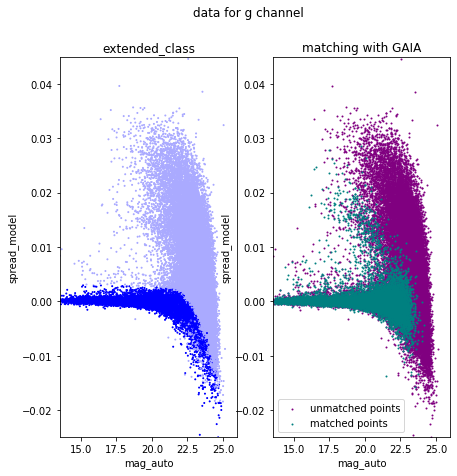

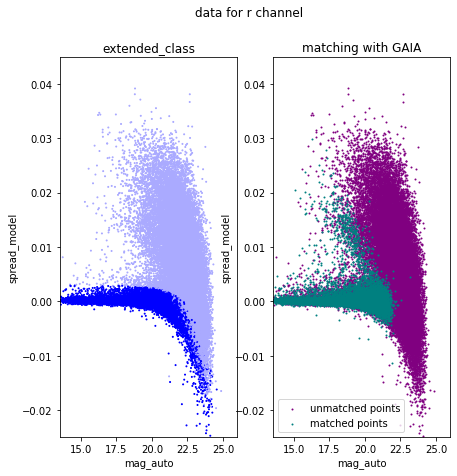

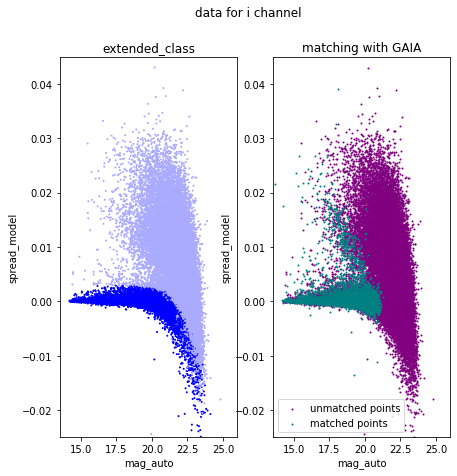

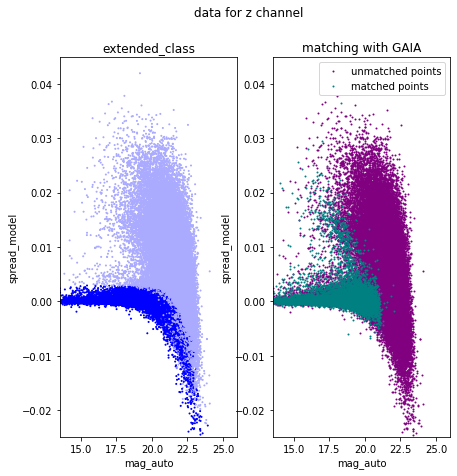

In [10]:
  # do single band analysis
  for band1 in bands:
    indices = apply_basic_cuts(band1)
    quick_object_id = np.array(delve_df['quick_object_id'][indices])
    matches = np.isin(quick_object_id,ids)
    mag_auto, spread_model, spreaderr_model, weight, extended_class = create_arrays()
    extended_class_match, average_class_match = calculate_extended_class(band1)
    gaia_contamination(band1)
    

In [11]:
  # do dual band analysis
  for band1 in bands:
    for band2 in bands:
      if band2 > band1:
        indices = apply_basic_cuts(band1,band2)
        quick_object_id = np.array(delve_df['quick_object_id'][indices])
        matches = np.isin(quick_object_id,ids)
        mag_auto, spread_model, spreaderr_model, weight, extended_class = create_arrays()
        extended_class_match, average_class_match = calculate_extended_class(band1,band2)
        gaia_contamination(band1,band2)
        
  # do triple band analysis
  for band1 in bands:
    for band2 in bands:
      for band3 in bands:
        if band2 > band1:
          if band3 > band2:
            indices = apply_basic_cuts(band1,band2,band3)
            quick_object_id = np.array(delve_df['quick_object_id'][indices])
            matches = np.isin(quick_object_id,ids)
            mag_auto, spread_model, spreaderr_model, weight, extended_class = create_arrays()
            extended_class_match, average_class_match = calculate_extended_class(band1,band2,band3)
            gaia_contamination(band1,band2,band3)

  # do quadruple band analysis
  for band1 in bands:
    for band2 in bands:
      for band3 in bands:
        for band4 in bands:
          if band2 > band1:
            if band3 > band2:
              if band4 > band3:
                indices = apply_basic_cuts(band1,band2,band3,band4)
                quick_object_id = np.array(delve_df['quick_object_id'][indices])
                matches = np.isin(quick_object_id,ids)
                mag_auto, spread_model, spreaderr_model, weight, extended_class = create_arrays()
                extended_class_match, average_class_match = calculate_extended_class(band1,band2,band3,band4)
                gaia_contamination(band1,band2,band3,band4)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).